<a href="https://colab.research.google.com/github/NinaAbeyratne/domain-shift-medical-segmentation/blob/main/Model_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pickle
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [33]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

In [36]:
# Base directory
BASE_DIR = Path('/content/drive/MyDrive/MV CW/V2')

DATA_DIR = BASE_DIR / 'data' / 'processed'
print(BASE_DIR)

/content/drive/MyDrive/MV CW/V2


In [37]:
BASE_DIR.mkdir(parents=True, exist_ok=True)
(DATA_DIR := BASE_DIR / 'data' / 'processed').mkdir(parents=True, exist_ok=True)
(MODEL_DIR := BASE_DIR / 'models').mkdir(parents=True, exist_ok=True)

print("BASE_DIR exists:", BASE_DIR.exists())
print("DATA_DIR exists:", DATA_DIR.exists())
print("MODEL_DIR exists:", MODEL_DIR.exists())

BASE_DIR exists: True
DATA_DIR exists: True
MODEL_DIR exists: True


## Dataset (PyTorch)

In [38]:
class MedicalSegmentationDataset(Dataset):
    """
    PyTorch Dataset for medical image segmentation.

    Args:
        images: Numpy array of images [N, H, W]
        masks: Numpy array of binary masks [N, H, W]
    """
    def __init__(self, images, masks):
        self.images = torch.FloatTensor(images)  # [N, H, W]
        self.masks = torch.FloatTensor(masks)    # [N, H, W]

    def __len__(self):
        return len(self.images)

    # def __getitem__(self, idx):
    #     image = self.images[idx].unsqueeze(0).contiguous()
    #     mask = self.masks[idx].unsqueeze(0).contiguous()
    #     return image, mask

    def __getitem__(self, idx):
        image = self.images[idx]  # already [1, H, W], no unsqueeze
        mask = self.masks[idx]    # already [1, H, W], no unsqueeze
        return image, mask

## Load Preprocessed Data

In [39]:
synthetic_train_images = np.load(BASE_DIR / 'data/processed/synthetic_train_images.npy')
synthetic_train_masks = np.load(BASE_DIR / 'data/processed/synthetic_train_masks.npy')
synthetic_val_images = np.load(BASE_DIR / 'data/processed/synthetic_val_images.npy')
synthetic_val_masks = np.load(BASE_DIR / 'data/processed/synthetic_val_masks.npy')

print(f"Synthetic training set: {synthetic_train_images.shape}")
print(f"Synthetic validation set: {synthetic_val_images.shape}")

Synthetic training set: (800, 1, 256, 256)
Synthetic validation set: (100, 1, 256, 256)


In [40]:
# Create datasets
train_dataset = MedicalSegmentationDataset(synthetic_train_images, synthetic_train_masks)
val_dataset = MedicalSegmentationDataset(synthetic_val_images, synthetic_val_masks)

# Create dataloaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print(f"\nBatch size: {batch_size}")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")


Batch size: 16
Training batches: 50
Validation batches: 7


In [41]:
import numpy as np
import hashlib

# Load preprocessed arrays
train_images = np.load('/content/drive/MyDrive/MV CW/V2/data/processed/synthetic_train_images.npy')
val_images = np.load('/content/drive/MyDrive/MV CW/V2/data/processed/synthetic_val_images.npy')

print(f"Train images: {train_images.shape}")
print(f"Val images:   {val_images.shape}")

# Function to hash an image
def hash_image(img):
    """Return a hash for a numpy image array"""
    img_bytes = img.tobytes()
    return hashlib.md5(img_bytes).hexdigest()

# Create sets of hashes
train_hashes = set(hash_image(img) for img in train_images)
val_hashes = set(hash_image(img) for img in val_images)

# Check for overlap
overlap = train_hashes & val_hashes
print(f"Number of duplicate images between train and val: {len(overlap)}")

if len(overlap) > 0:
    print("⚠️ Data leakage detected! Some images appear in both train and val sets.")
else:
    print("✅ No exact duplicates found between train and val sets.")


Train images: (800, 1, 256, 256)
Val images:   (100, 1, 256, 256)
Number of duplicate images between train and val: 0
✅ No exact duplicates found between train and val sets.


# U-Net Model

In [42]:
class DoubleConv(nn.Module):
    """
    Double convolution block: Conv -> BatchNorm -> ReLU -> Conv -> BatchNorm -> ReLU

    Standard building block in U-Net architecture.
    """
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

In [43]:
class UNet(nn.Module):
    """
    U-Net architecture for medical image segmentation.

    Architecture:
        Encoder: 64 -> 128 -> 256 -> 512 -> 1024 channels
        Decoder: 1024 -> 512 -> 256 -> 128 -> 64 channels
        Output: 1 channel (binary segmentation)

    Args:
        in_channels: Number of input channels (1 for grayscale)
        out_channels: Number of output channels (1 for binary segmentation)
    """
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()

        # Encoder (downsampling path)
        self.enc1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck
        self.bottleneck = DoubleConv(512, 1024)

        # Decoder (upsampling path)
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = DoubleConv(1024, 512)  # 1024 = 512 (upconv) + 512 (skip)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = DoubleConv(512, 256)   # 512 = 256 (upconv) + 256 (skip)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = DoubleConv(256, 128)   # 256 = 128 (upconv) + 128 (skip)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = DoubleConv(128, 64)    # 128 = 64 (upconv) + 64 (skip)

        # Output layer
        self.out = nn.Conv2d(64, out_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Encoder with skip connection storage
        enc1 = self.enc1(x)          # [B, 64, 256, 256]
        pool1 = self.pool1(enc1)     # [B, 64, 128, 128]

        enc2 = self.enc2(pool1)      # [B, 128, 128, 128]
        pool2 = self.pool2(enc2)     # [B, 128, 64, 64]

        enc3 = self.enc3(pool2)      # [B, 256, 64, 64]
        pool3 = self.pool3(enc3)     # [B, 256, 32, 32]

        enc4 = self.enc4(pool3)      # [B, 512, 32, 32]
        pool4 = self.pool4(enc4)     # [B, 512, 16, 16]

        # Bottleneck
        bottleneck = self.bottleneck(pool4)  # [B, 1024, 16, 16]

        # Decoder with skip connections
        up4 = self.upconv4(bottleneck)       # [B, 512, 32, 32]
        cat4 = torch.cat([up4, enc4], dim=1) # [B, 1024, 32, 32]
        dec4 = self.dec4(cat4)               # [B, 512, 32, 32]

        up3 = self.upconv3(dec4)             # [B, 256, 64, 64]
        cat3 = torch.cat([up3, enc3], dim=1) # [B, 512, 64, 64]
        dec3 = self.dec3(cat3)               # [B, 256, 64, 64]

        up2 = self.upconv2(dec3)             # [B, 128, 128, 128]
        cat2 = torch.cat([up2, enc2], dim=1) # [B, 256, 128, 128]
        dec2 = self.dec2(cat2)               # [B, 128, 128, 128]

        up1 = self.upconv1(dec2)             # [B, 64, 256, 256]
        cat1 = torch.cat([up1, enc1], dim=1) # [B, 128, 256, 256]
        dec1 = self.dec1(cat1)               # [B, 64, 256, 256]

        # Output
        out = self.out(dec1)                 # [B, 1, 256, 256]
        out = self.sigmoid(out)              # Apply sigmoid for binary segmentation

        return out

In [44]:
# Initialize model
model = UNet(in_channels=1, out_channels=1).to(device)

In [45]:
# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

In [46]:
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"\nModel summary:")
print(model)

Total parameters: 31,036,481
Trainable parameters: 31,036,481

Model summary:
UNet(
  (enc1): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      

A standard U-Net architecture with approximately 31 million trainable parameters was implemented. The model consists of a symmetric encoder–decoder structure with skip connections and Batch Normalization after each convolutional layer. The network was trained from scratch on synthetic data

# Loss Function

In [47]:
class DiceBCELoss(nn.Module):
    """
    Combined Dice Loss and Binary Cross-Entropy Loss.

    Dice Loss addresses class imbalance and directly optimizes overlap.
    BCE Loss provides stable pixel-wise gradients.
    """
    def __init__(self, weight_bce=0.5, weight_dice=0.5):
        super(DiceBCELoss, self).__init__()
        self.weight_bce = weight_bce
        self.weight_dice = weight_dice
        self.bce = nn.BCELoss()

    def forward(self, pred, target):
        # Binary Cross-Entropy
        bce_loss = self.bce(pred, target)

        # Dice Loss
        smooth = 1e-5  # Avoid division by zero
        pred_flat = pred.view(-1)
        target_flat = target.view(-1)

        intersection = (pred_flat * target_flat).sum()
        dice_coeff = (2. * intersection + smooth) / (pred_flat.sum() + target_flat.sum() + smooth)
        dice_loss = 1 - dice_coeff

        # Combined loss
        total_loss = self.weight_bce * bce_loss + self.weight_dice * dice_loss

        return total_loss, bce_loss.item(), dice_loss.item()

In [48]:
criterion = DiceBCELoss(weight_bce=0.5, weight_dice=0.5)

# Training

In [49]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 20

In [50]:
print("\n" + "="*70)
print("TRAINING CONFIGURATION")
print("="*70)
print(f"Optimizer: Adam")
print(f"Learning rate: 1e-4")
print(f"Number of epochs: {num_epochs}")
print(f"Batch size: {batch_size}")
print(f"Loss function: Combined BCE + Dice")


TRAINING CONFIGURATION
Optimizer: Adam
Learning rate: 1e-4
Number of epochs: 20
Batch size: 16
Loss function: Combined BCE + Dice


In [51]:
def calculate_dice_coefficient(pred, target, threshold=0.5):
    """
    Calculate Dice coefficient for binary segmentation.

    Args:
        pred: Predicted probabilities [B, 1, H, W]
        target: Ground truth binary masks [B, 1, H, W]
        threshold: Probability threshold for binary prediction

    Returns:
        dice: Dice coefficient (scalar)
    """
    pred_binary = (pred > threshold).float()

    smooth = 1e-5
    pred_flat = pred_binary.view(-1)
    target_flat = target.view(-1)

    intersection = (pred_flat * target_flat).sum()
    dice = (2. * intersection + smooth) / (pred_flat.sum() + target_flat.sum() + smooth)

    return dice.item()

In [52]:
def train_epoch(model, loader, criterion, optimizer, device):
    """Train for one epoch."""
    model.train()

    total_loss = 0.0
    total_bce = 0.0
    total_dice_loss = 0.0
    total_dice_score = 0.0

    pbar = tqdm(loader, desc='Training')
    for images, masks in pbar:
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        outputs = model(images)
        loss, bce, dice_loss = criterion(outputs, masks)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Metrics
        dice_score = calculate_dice_coefficient(outputs, masks)

        total_loss += loss.item()
        total_bce += bce
        total_dice_loss += dice_loss
        total_dice_score += dice_score

        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'dice': f'{dice_score:.4f}'
        })

    n_batches = len(loader)
    return {
        'loss': total_loss / n_batches,
        'bce': total_bce / n_batches,
        'dice_loss': total_dice_loss / n_batches,
        'dice_score': total_dice_score / n_batches
    }

In [53]:
def validate_epoch(model, loader, criterion, device):
    """Validate for one epoch."""
    model.eval()

    total_loss = 0.0
    total_bce = 0.0
    total_dice_loss = 0.0
    total_dice_score = 0.0

    with torch.no_grad():
        pbar = tqdm(loader, desc='Validation')
        for images, masks in pbar:
            images = images.to(device)
            masks = masks.to(device)

            # Forward pass
            outputs = model(images)
            loss, bce, dice_loss = criterion(outputs, masks)

            # Metrics
            dice_score = calculate_dice_coefficient(outputs, masks)

            total_loss += loss.item()
            total_bce += bce
            total_dice_loss += dice_loss
            total_dice_score += dice_score

            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'dice': f'{dice_score:.4f}'
            })

    n_batches = len(loader)
    return {
        'loss': total_loss / n_batches,
        'bce': total_bce / n_batches,
        'dice_loss': total_dice_loss / n_batches,
        'dice_score': total_dice_score / n_batches
    }

In [54]:
from pathlib import Path
Path('models').mkdir(parents=True, exist_ok=True)

In [55]:
print("\n" + "="*70)
print("STARTING TRAINING")
print("="*70)

history = {
    'train_loss': [],
    'train_bce': [],
    'train_dice_loss': [],
    'train_dice': [],
    'val_loss': [],
    'val_bce': [],
    'val_dice_loss': [],
    'val_dice': []
}

best_val_dice = 0.0

import time
epoch_times = []

for epoch in range(num_epochs):

    epoch_start_time = time.time()

    print(f"\nEpoch {epoch+1}/{num_epochs}")

    # Train
    train_metrics = train_epoch(model, train_loader, criterion, optimizer, device)

    # Validate
    val_metrics = validate_epoch(model, val_loader, criterion, device)

    if device.type == 'cuda':
        torch.cuda.synchronize()

    epoch_duration = time.time() - epoch_start_time
    epoch_times.append(epoch_duration)

    # Store history
    history['train_loss'].append(train_metrics['loss'])
    history['train_bce'].append(train_metrics['bce'])
    history['train_dice_loss'].append(train_metrics['dice_loss'])
    history['train_dice'].append(train_metrics['dice_score'])

    history['val_loss'].append(val_metrics['loss'])
    history['val_bce'].append(val_metrics['bce'])
    history['val_dice_loss'].append(val_metrics['dice_loss'])
    history['val_dice'].append(val_metrics['dice_score'])

    # Print summary
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print(f"\nEpoch {epoch+1} Summary:")
    print(f"  Train Loss: {train_metrics['loss']:.4f} | Train Dice: {train_metrics['dice_score']:.4f}")
    print(f"  Val Loss:   {val_metrics['loss']:.4f} | Val Dice:   {val_metrics['dice_score']:.4f}")
    print(f"  Epoch Time: {epoch_duration:.2f} seconds")

    # Save best model
    if val_metrics['dice_score'] > best_val_dice:
        best_val_dice = val_metrics['dice_score']
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_dice': best_val_dice,
        }, 'models/unet_best.pth')
        print(f"  → Best model saved! (Val Dice: {best_val_dice:.4f})")


STARTING TRAINING

Epoch 1/20


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.42it/s, loss=0.2917, dice=0.9856]



Epoch 1/20

Epoch 1 Summary:
  Train Loss: 0.3629 | Train Dice: 0.9634
  Val Loss:   0.3075 | Val Dice:   0.9852
  Epoch Time: 39.66 seconds
  → Best model saved! (Val Dice: 0.9852)

Epoch 2/20


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.51it/s, loss=0.2652, dice=0.9950]



Epoch 2/20

Epoch 2 Summary:
  Train Loss: 0.2899 | Train Dice: 0.9924
  Val Loss:   0.2806 | Val Dice:   0.9944
  Epoch Time: 39.43 seconds
  → Best model saved! (Val Dice: 0.9944)

Epoch 3/20


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.48it/s, loss=0.2410, dice=0.9972]



Epoch 3/20

Epoch 3 Summary:
  Train Loss: 0.2655 | Train Dice: 0.9954
  Val Loss:   0.2555 | Val Dice:   0.9967
  Epoch Time: 39.27 seconds
  → Best model saved! (Val Dice: 0.9967)

Epoch 4/20


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.49it/s, loss=0.2170, dice=0.9984]



Epoch 4/20

Epoch 4 Summary:
  Train Loss: 0.2420 | Train Dice: 0.9971
  Val Loss:   0.2306 | Val Dice:   0.9981
  Epoch Time: 39.51 seconds
  → Best model saved! (Val Dice: 0.9981)

Epoch 5/20


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.50it/s, loss=0.1989, dice=0.9993]



Epoch 5/20

Epoch 5 Summary:
  Train Loss: 0.2208 | Train Dice: 0.9986
  Val Loss:   0.2120 | Val Dice:   0.9991
  Epoch Time: 39.34 seconds
  → Best model saved! (Val Dice: 0.9991)

Epoch 6/20


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.47it/s, loss=0.1831, dice=0.9996]



Epoch 6/20

Epoch 6 Summary:
  Train Loss: 0.2041 | Train Dice: 0.9993
  Val Loss:   0.1955 | Val Dice:   0.9995
  Epoch Time: 39.58 seconds
  → Best model saved! (Val Dice: 0.9995)

Epoch 7/20


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.51it/s, loss=0.1681, dice=0.9998]



Epoch 7/20

Epoch 7 Summary:
  Train Loss: 0.1888 | Train Dice: 0.9996
  Val Loss:   0.1799 | Val Dice:   0.9997
  Epoch Time: 39.29 seconds
  → Best model saved! (Val Dice: 0.9997)

Epoch 8/20


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.46it/s, loss=0.1554, dice=0.9999]



Epoch 8/20

Epoch 8 Summary:
  Train Loss: 0.1744 | Train Dice: 0.9997
  Val Loss:   0.1666 | Val Dice:   0.9998
  Epoch Time: 39.45 seconds
  → Best model saved! (Val Dice: 0.9998)

Epoch 9/20


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.52it/s, loss=0.1431, dice=0.9999]



Epoch 9/20

Epoch 9 Summary:
  Train Loss: 0.1611 | Train Dice: 0.9998
  Val Loss:   0.1537 | Val Dice:   0.9998
  Epoch Time: 39.34 seconds
  → Best model saved! (Val Dice: 0.9998)

Epoch 10/20


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.48it/s, loss=0.1320, dice=0.9999]



Epoch 10/20

Epoch 10 Summary:
  Train Loss: 0.1488 | Train Dice: 0.9998
  Val Loss:   0.1421 | Val Dice:   0.9999
  Epoch Time: 39.36 seconds
  → Best model saved! (Val Dice: 0.9999)

Epoch 11/20


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.48it/s, loss=0.1224, dice=0.9999]



Epoch 11/20

Epoch 11 Summary:
  Train Loss: 0.1374 | Train Dice: 0.9999
  Val Loss:   0.1319 | Val Dice:   0.9999
  Epoch Time: 39.34 seconds
  → Best model saved! (Val Dice: 0.9999)

Epoch 12/20


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.48it/s, loss=0.1124, dice=1.0000]



Epoch 12/20

Epoch 12 Summary:
  Train Loss: 0.1268 | Train Dice: 0.9999
  Val Loss:   0.1213 | Val Dice:   0.9999
  Epoch Time: 39.45 seconds
  → Best model saved! (Val Dice: 0.9999)

Epoch 13/20


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.48it/s, loss=0.1039, dice=1.0000]



Epoch 13/20

Epoch 13 Summary:
  Train Loss: 0.1171 | Train Dice: 0.9999
  Val Loss:   0.1123 | Val Dice:   0.9999
  Epoch Time: 39.36 seconds
  → Best model saved! (Val Dice: 0.9999)

Epoch 14/20


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.46it/s, loss=0.0946, dice=1.0000]



Epoch 14/20

Epoch 14 Summary:
  Train Loss: 0.1082 | Train Dice: 1.0000
  Val Loss:   0.1024 | Val Dice:   1.0000
  Epoch Time: 39.66 seconds
  → Best model saved! (Val Dice: 1.0000)

Epoch 15/20


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.48it/s, loss=0.0885, dice=1.0000]



Epoch 15/20

Epoch 15 Summary:
  Train Loss: 0.0999 | Train Dice: 1.0000
  Val Loss:   0.0958 | Val Dice:   1.0000
  Epoch Time: 39.46 seconds
  → Best model saved! (Val Dice: 1.0000)

Epoch 16/20


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.43it/s, loss=0.0818, dice=1.0000]



Epoch 16/20

Epoch 16 Summary:
  Train Loss: 0.0924 | Train Dice: 1.0000
  Val Loss:   0.0886 | Val Dice:   1.0000
  Epoch Time: 39.57 seconds
  → Best model saved! (Val Dice: 1.0000)

Epoch 17/20


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.47it/s, loss=0.0751, dice=1.0000]



Epoch 17/20

Epoch 17 Summary:
  Train Loss: 0.0855 | Train Dice: 1.0000
  Val Loss:   0.0815 | Val Dice:   1.0000
  Epoch Time: 39.57 seconds
  → Best model saved! (Val Dice: 1.0000)

Epoch 18/20


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.46it/s, loss=0.0700, dice=1.0000]



Epoch 18/20

Epoch 18 Summary:
  Train Loss: 0.0792 | Train Dice: 1.0000
  Val Loss:   0.0760 | Val Dice:   1.0000
  Epoch Time: 39.44 seconds
  → Best model saved! (Val Dice: 1.0000)

Epoch 19/20


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.47it/s, loss=0.0645, dice=1.0000]



Epoch 19/20

Epoch 19 Summary:
  Train Loss: 0.0733 | Train Dice: 1.0000
  Val Loss:   0.0702 | Val Dice:   1.0000
  Epoch Time: 39.17 seconds
  → Best model saved! (Val Dice: 1.0000)

Epoch 20/20


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.44it/s, loss=0.0602, dice=1.0000]



Epoch 20/20

Epoch 20 Summary:
  Train Loss: 0.0681 | Train Dice: 1.0000
  Val Loss:   0.0655 | Val Dice:   1.0000
  Epoch Time: 39.60 seconds
  → Best model saved! (Val Dice: 1.0000)


In [56]:
# Drive models directory
DRIVE_MODELS_DIR = Path('/content/drive/MyDrive/MV CW/V2/models')
DRIVE_MODELS_DIR.mkdir(parents=True, exist_ok=True)

# Define which epochs you want to save explicitly
save_epochs = [5, 8, 10, 15, 20]

for epoch in range(num_epochs):
    # ... your training and validation code ...

    # Save explicit checkpoints at chosen epochs
    if (epoch + 1) in save_epochs:
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_dice': val_metrics['dice_score'],  # use current epoch's val_dice
        }, DRIVE_MODELS_DIR / f'unet_epoch{epoch+1}.pth')
        print(f"Checkpoint saved for epoch {epoch+1} (Val Dice: {val_metrics['dice_score']:.4f})")

    # Save best model separately
    if val_metrics['dice_score'] > best_val_dice:
        best_val_dice = val_metrics['dice_score']
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_dice': best_val_dice,
        }, DRIVE_MODELS_DIR / 'unet_best.pth')
        print(f"→ Best model updated at epoch {epoch+1} (Val Dice: {best_val_dice:.4f})")

# Save training history at the end
with open(DRIVE_MODELS_DIR / 'training_history.pkl', 'wb') as f:
    pickle.dump(history, f)

print("Training completed and models saved to Google Drive")
print(f"Best validation Dice: {best_val_dice:.4f}")


Checkpoint saved for epoch 5 (Val Dice: 1.0000)
Checkpoint saved for epoch 8 (Val Dice: 1.0000)
Checkpoint saved for epoch 10 (Val Dice: 1.0000)
Checkpoint saved for epoch 15 (Val Dice: 1.0000)
Checkpoint saved for epoch 20 (Val Dice: 1.0000)
Training completed and models saved to Google Drive
Best validation Dice: 1.0000


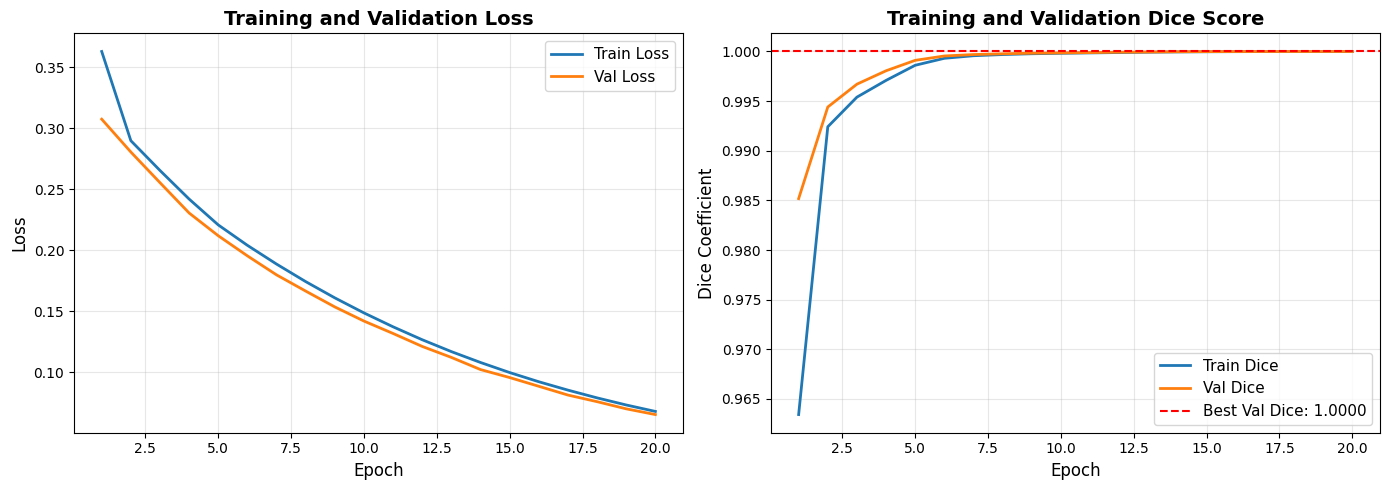


Training curves saved to models/training_curves.png


In [57]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curves
epochs_range = range(1, num_epochs + 1)
axes[0].plot(epochs_range, history['train_loss'], label='Train Loss', linewidth=2)
axes[0].plot(epochs_range, history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(alpha=0.3)

# Dice coefficient curves
axes[1].plot(epochs_range, history['train_dice'], label='Train Dice', linewidth=2)
axes[1].plot(epochs_range, history['val_dice'], label='Val Dice', linewidth=2)
axes[1].axhline(y=best_val_dice, color='r', linestyle='--',
                label=f'Best Val Dice: {best_val_dice:.4f}', linewidth=1.5)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Dice Coefficient', fontsize=12)
axes[1].set_title('Training and Validation Dice Score', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('models/training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nTraining curves saved to models/training_curves.png")

### Training time

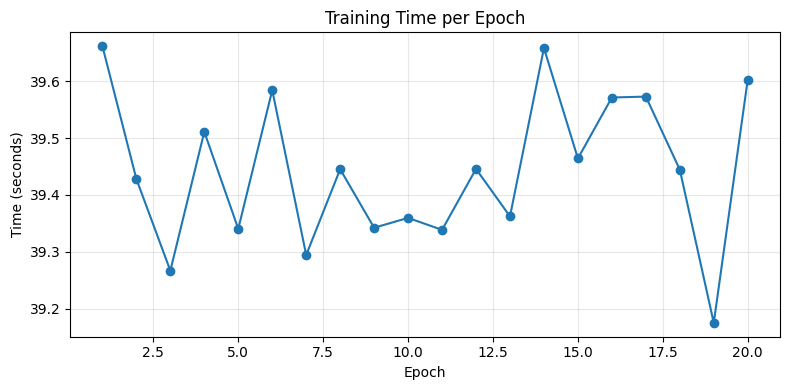

In [58]:
plt.figure(figsize=(8, 4))
plt.plot(range(1, num_epochs + 1), epoch_times, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Time (seconds)')
plt.title('Training Time per Epoch')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Sample Predictions on Synthetic Validation Set

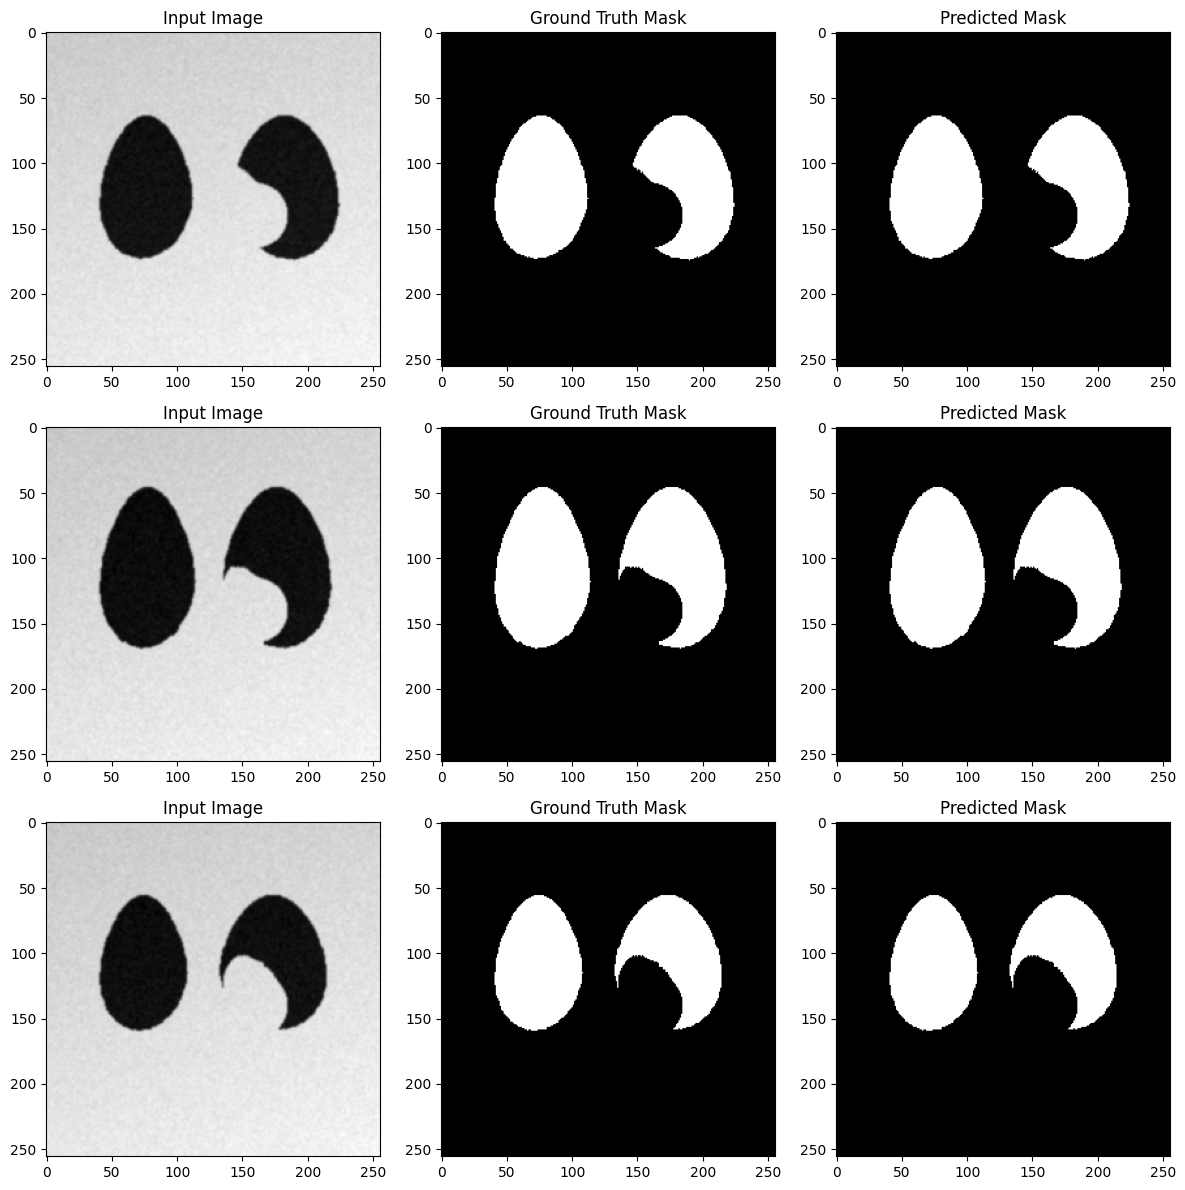

In [59]:
model.eval()
num_samples = 3
fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4*num_samples))

for i in range(num_samples):
    img = synthetic_val_images[i]   # [1, H, W]
    mask = synthetic_val_masks[i]   # [1, H, W]

    with torch.no_grad():
        input_tensor = torch.FloatTensor(img).unsqueeze(0).to(device)
        # shape: [1, 1, H, W]

        pred = model(input_tensor).cpu().squeeze().numpy()
        pred_binary = (pred > 0.5).astype(np.float32)

    axes[i, 0].imshow(img.squeeze(), cmap='gray')
    axes[i, 0].set_title('Input Image')

    axes[i, 1].imshow(mask.squeeze(), cmap='gray')
    axes[i, 1].set_title('Ground Truth Mask')

    axes[i, 2].imshow(pred_binary, cmap='gray')
    axes[i, 2].set_title('Predicted Mask')

plt.tight_layout()
plt.show()

### Dice Distribution

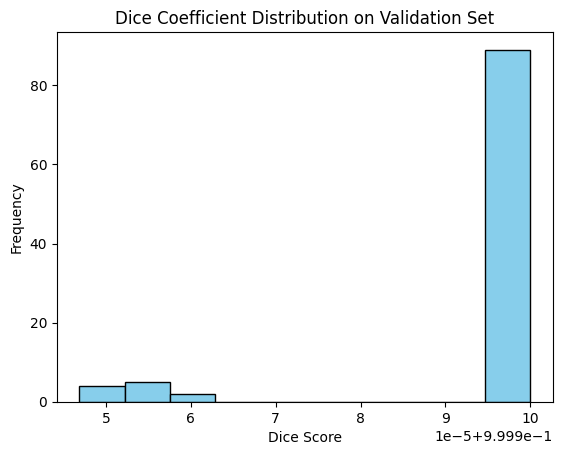

In [60]:
dice_scores = []
model.eval()
with torch.no_grad():
    for images, masks in val_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        for out, mask in zip(outputs, masks):
            dice_scores.append(calculate_dice_coefficient(out.unsqueeze(0), mask.unsqueeze(0)))

plt.hist(dice_scores, bins=10, color='skyblue', edgecolor='k')
plt.title("Dice Coefficient Distribution on Validation Set")
plt.xlabel("Dice Score")
plt.ylabel("Frequency")
plt.show()

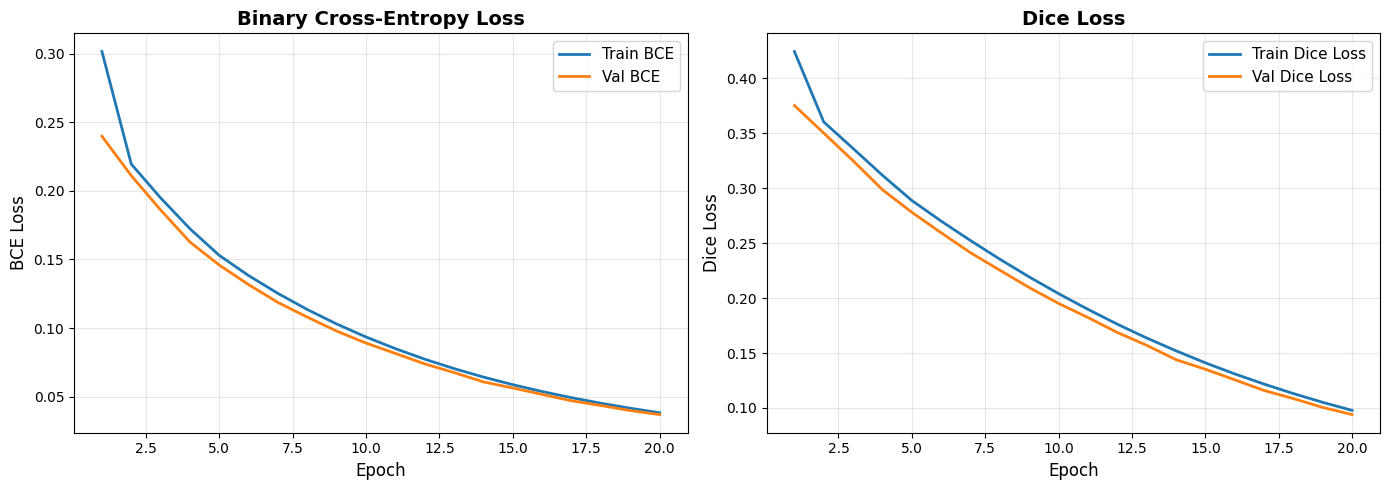


BCE and Dice loss curves saved to models/bce_dice_loss_curves.png


In [61]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

epochs_range = range(1, num_epochs + 1)

# BCE Loss
axes[0].plot(epochs_range, history['train_bce'], label='Train BCE', linewidth=2)
axes[0].plot(epochs_range, history['val_bce'], label='Val BCE', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('BCE Loss', fontsize=12)
axes[0].set_title('Binary Cross-Entropy Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(alpha=0.3)

# Dice Loss
axes[1].plot(epochs_range, history['train_dice_loss'], label='Train Dice Loss', linewidth=2)
axes[1].plot(epochs_range, history['val_dice_loss'], label='Val Dice Loss', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Dice Loss', fontsize=12)
axes[1].set_title('Dice Loss', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('models/bce_dice_loss_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nBCE and Dice loss curves saved to models/bce_dice_loss_curves.png")
